# Import Files

D:\Temp\ipykernel_16232\1402222330.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_16232\1402222330.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_16232\1402222330.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")


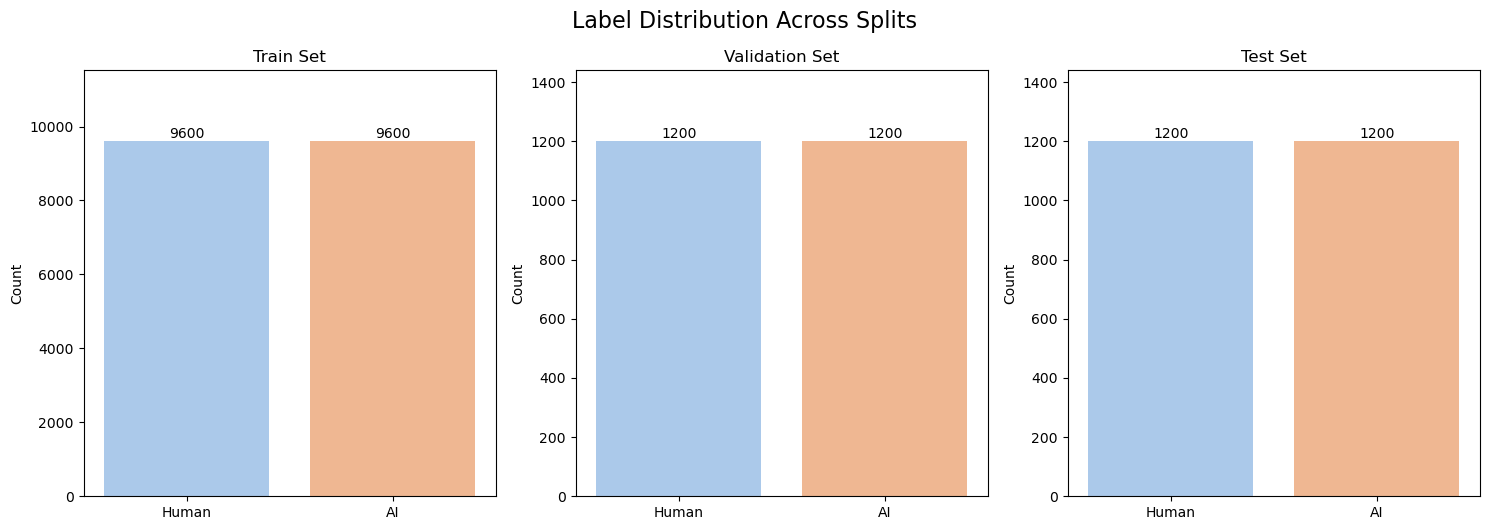

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

df = pd.read_csv("../Final_Dataset_Fixed.csv")
df['label'] = df['label'].map({'human': 0, 'ai': 1})

#split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.2, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)
splits = {
    "Train": train_labels,
    "Validation": val_labels,
    "Test": test_labels,
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (split_name, split_labels) in enumerate(splits.items()):
    counts = pd.Series(split_labels).value_counts().sort_index()
    class_names = ['Human', 'AI']
    sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
    axs[i].set_title(f"{split_name} Set")
    axs[i].set_ylabel("Count")
    axs[i].set_ylim(0, max(counts.values) * 1.2)
    for j, count in enumerate(counts.values):
        axs[i].text(j, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Label Distribution Across Splits", fontsize=16, y=1.05)
plt.savefig("Label Distribution.png")
plt.show()

# Tokenizer

In [2]:
model_name = "sagorsarker/bangla-gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

class BengaliDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

train_dataset = BengaliDataset(train_encodings, train_labels)
val_dataset = BengaliDataset(val_encodings, val_labels)
test_dataset = BengaliDataset(test_encodings, test_labels)

#Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


c:\Users\Jim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: sagorsarker/bangla-gpt2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

# Training

In [ ]:
#Training args
training_args = TrainingArguments(
    output_dir="./banglagpt2_results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    report_to="none",
    seed=42,
    disable_tqdm=False,
)

#Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

In [ ]:
#Logs
logs = trainer.state.log_history

train_loss, val_loss, train_acc, val_acc, epochs = [], [], [], [], []

for log in logs:
    if "epoch" in log:
        if "loss" in log and "eval_loss" not in log:
            train_loss.append(log["loss"])
            epochs.append(log["epoch"])
        if "eval_loss" in log:
            val_loss.append(log["eval_loss"])
            val_acc.append(log["eval_accuracy"])
        if "train_accuracy" in log:
            train_acc.append(log["train_accuracy"])
if not train_acc:
    train_preds_output = trainer.predict(train_dataset)
    train_preds = np.argmax(train_preds_output.predictions, axis=-1)
    train_acc_value = accuracy_score(train_preds_output.label_ids, train_preds)
    train_acc = [train_acc_value] * len(val_acc)


# Curves Plotting

In [ ]:
#Loss Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
best_epoch = np.argmin(val_loss)
plt.axvline(epochs[best_epoch], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("Training vs Validation Loss.png")
plt.show()

#Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
best_epoch_acc = np.argmax(val_acc)
plt.axvline(epochs[best_epoch_acc], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("Training vs Validation Accuracy.png")
plt.show()

# Evaluation

In [ ]:
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)

#Confusion Matrix
cm = confusion_matrix(test_labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human","AI"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()
report = classification_report(test_labels, preds, target_names=["Human", "AI"], digits=4)
print("Classification Report (Test Set):\n")
print(report)

In [ ]:
#Save the best model
trainer.save_model("./banglagpt2_model")
tokenizer.save_pretrained("./banglagpt2_tokenizer")

# About Model

In [ ]:
from transformers import AutoConfig
print("\nModel architecture:")
print(model)

#Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

config = AutoConfig.from_pretrained("sagorsarker/bangla-gpt2")
print("\nModel configuration:")
print(config)